In [7]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)


from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler)

from sklearn.model_selection import(
    train_test_split,
    cross_val_score
)

from sklearn.linear_model import(
    Ridge,
    Lasso,
    ElasticNet,
    LinearRegression
)

from sklearn.feature_selection import(
    VarianceThreshold,
    chi2,
    SelectKBest
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew
import xgboost as xgb

In [8]:
from IPython.core.debugger import set_trace
from collections import defaultdict
import math


class LabelCountEncoder(object):
    def __init__(self):
        self.count_dict = {}
    
    def fit(self, column):
        # This gives you a dictionary with level as the key and counts as the value
        count = column.value_counts().to_dict()
        # We want to rank the key by its value and use the rank as the new value
        for rank, item in enumerate(sorted(count.items(), key=lambda x: x[1])):
            self.count_dict[item[0]] = rank+1
    
    def transform(self, column):
        # If a category only appears in the test set, we will assign the value to zero.
        # missing = 0
        return column.apply(lambda x: self.count_dict.get(x,0))
    
    def fit_transform(self, column):
        self.fit(column)
        return self.transform(column)
    

# replace a list of items with a list of new_items in list words
def replace_features(words, items, new_items):
    for i, _ in enumerate(items):
        words[words.index(items[i])]=new_items[i]
    return words


# utility function for sns FacetGrid mapping
def plot_box (x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    

class House(object):
    """NYC Data Science Academy Project 3 - House Price Prediction"""
    def __init__(self, train_file, test_file, describe_file):
        self.__train_data = pd.read_csv(train_file, na_values='')
        self.__test_data = pd.read_csv(test_file, na_values='')
        self.__desc_file = describe_file
        self.__feature_names = defaultdict(list)
        self.__ordinal_levels = ["Reg", "5", "TA", "No", "Unf",
                               "MnPrv", "Y", "Mod", "HLS", "1Fam"]
        self.__feature_numeric = []
        self.__feature_ordinal = []
        self.__feature_category = []
        plt.style.use('ggplot')
        
    def get_train_data(self):
        return self.__train_data
    
    def get_test_data(self):
        return self.__test_data
    
    def get_feature_names(self):
        return self.__feature_names
    
    def get_feature_numeric(self):
        return self.__feature_numeric
    
    def get_ordinal_levels(self):
        return self.__ordinal_levels
    
    def get_feature_ordinal(self):
        return self.__feature_ordinal
    
    def get_feature_category(self):
        return self.__feature_category
        
    def train_head(self,n=5):
        print(self.__train_data.head(n))
        
    def test_head(self,n=5):
        print(self.__test_data.head(n))
        
    def train_shape(self):
        print(self.__train_data.shape)
        
    def test_shape(self):
        print(self.__test_data.shape)
        
    def train_info(self):
        print(self.__train_data.info())
        
    def test_info(self):
        print(self.__test_data.info())
        
    # parse description file
    def parse_features(self):
        with open(self.__desc_file, 'r') as file:
            item = ''
            lines = file.readlines()
            for line in lines:
                # check empty line
                line_stripped = line.strip()
                if line_stripped: 
                    if line_stripped.find(':',0,min(20, len(line_stripped))) != -1:
                        item = line_stripped.split(':')[0]
                    else:
                        level = line_stripped.split('\t')[0]
                        self.__feature_names[item].append(level)
                            
    # check the differences between description file and dataset                        
    def check_features(self):
        # check each features
        for feature in self.__feature_names:
            # check features against columns in train data
            if feature in (self.__train_data.columns):
                # check the number of levels in feature
                # skip the check if the levels are numeric
                if  self.__feature_names[feature] != None and (not self.__feature_names[feature][0].isnumeric()):
                    diff = set(self.__train_data[feature]).difference(set(self.__feature_names[feature]))
                    # ignore the difference if it is of type nan or NA
                    if len(diff) and not (len(diff) == 1 and (np.nan in diff)):
                        print('%s:'%feature)
                        print('\ntrain: ', set(self.__train_data[feature]))
                        print('\ndescription: ', set(self.__feature_names[feature]))
                        print('\ndifference: ', diff, '\n\n')
            else:
                print('%s is not in the dataset.\n\n' % feature)
                
    # manually reconcile feature difference 
    def reconcile_features(self):
        self.__feature_names['MSZoning']=replace_features(self.__feature_names['MSZoning'],
                                                       ['C'],['C (all)'])
        self.__feature_names['Neighborhood']=replace_features(self.__feature_names['Neighborhood'],
                                                       ['Names'],['NAmes'])
        self.__feature_names['BldgType']=replace_features(self.__feature_names['BldgType'],
                                                       ['Duplx','TwnhsI','2FmCon'],
                                                       ['Duplex', 'Twnhs', '2fmCon'])
        self.__feature_names['Exterior2nd']=replace_features(self.__feature_names['Exterior2nd'],
                                                       ['CemntBd','BrkComm'],
                                                       ['CmentBd','Brk Cmn'])
        self.__feature_names['Exterior2nd'].append('Wd Shng')
        self.__feature_names['SaleType']=replace_features(self.__feature_names['SaleType'],
                                                       ['WD '],['WD'])
        # missing variables in data description file
        # self.__feature_names['BedroomAbvGr']=['0','1','2','3','4','5','6','7','8']
        # self.__feature_names['KitchenAbvGr']=['0','1','2','3']
        
    # convert column training data to proper data type
    def convert_train(self):
        for feature in (self.__train_data.columns):
            if feature in self.__feature_names:
                self.__train_data[feature].astype(pd.api.types.CategoricalDtype(categories=self.__feature_names[feature]))
            else:
                self.__train_data[feature].astype('int', errors='ignore')
                
    # convert column testing data to proper data type
    def convert_test(self):
        for feature in (self.__test_data.columns):
            if feature in self.__feature_names:
                self.__test_data[feature].astype(pd.api.types.CategoricalDtype(categories=self.__feature_names[feature]))
            else:
                self.__test_data[feature].astype('int', errors='ignore')
                
    # Sales Histogram
    def sales_hist(self):
        fig, axes = plt.subplots(1,2, figsize=(14,6))
        self.__train_data['SalePrice'].plot.hist(bins=20, ax=axes[0])
        axes[0].set_xlabel('House Price')
        pd.Series(map(math.log,self.__train_data['SalePrice']+1)).plot.hist(bins=20, ax=axes[1])
        axes[1].set_xlabel('House Price - Log Scale')
        plt.show()

    # Define continuous, categorial and ordinal variables
    def classify_features(self):
        # 'OverallQual' and 'OverallCond' already have numeric ordinal levels
        del self.__feature_names['OverallQual']
        del self.__feature_names['OverallCond']
        self.__feature_numeric = list(set(self.__train_data.columns) - set(self.__feature_names.keys()))
        self.__feature_numeric.remove('Id')
        for feature in self.__feature_names:
            if(set(self.__ordinal_levels).intersection(set(self.__feature_names[feature]))):
                self.__feature_ordinal.append(feature)
        self.__feature_category = list(set(self.__feature_names) - set(self.__feature_ordinal))
        
    # pairwise plot for continuous variable, remove variables with missing values     
    def pair_plot_features(self):
        cols = self.__feature_numeric
        # remove features with missing values
        cols.remove('GarageYrBlt')
        cols.remove('LotFrontage')
        cols.remove('MasVnrArea')
        # sns.set()
        sns.pairplot(self.__train_data[cols], size = 2.5)
        plt.show()
        
    # numeric feature grid plot
    def numeric_feature_grid_plot(self):
        merge_data = pd.DataFrame(np.tile(self.__train_data['SalePrice'], len(self.__feature_numeric)), columns=['SalePrice'])
        df = pd.melt(self.__train_data, value_vars=self.__feature_numeric)
        merge_data = pd.concat([merge_data, df], axis=1)
        pic = sns.FacetGrid(merge_data, col='variable', col_wrap=3, sharex=False, sharey=False, size=4)
        pic = pic.map(plt.scatter,'value', 'SalePrice')
        
    # category feature grid plot
    def category_feature_grid_plot(self):
        df = pd.melt(self.__train_data, id_vars=['SalePrice'], value_vars=self.__feature_names)
        pic = sns.FacetGrid(df, col="variable",  col_wrap=3, sharex=False, sharey=False, size=4)
        pic = pic.map(plot_box, "value", "SalePrice") 
        
    # collelation plot for each numerical variable against SalePrice
    def corr_plot_with_price(self):
        corr_df = pd.DataFrame()
        corr_df['feature'] = self.__feature_ordinal
        corr_df['correlation'] = [self.__train_data[feature].corr(self.__train_data['SalePrice'],
                                                               'spearman') for feature in self.__feature_ordinal]
        corr_df = corr_df.sort_values('correlation')
        plt.figure(figsize=(12, 0.5*len(self.__feature_ordinal)))
        sns.barplot(data=corr_df, y='feature', x='correlation', orient='h')
        
    # convert ordinal data to numerical
    def transform_ordinal(self):
        ord_cols = ['ExterQual', 'ExterCond','BsmtCond','HeatingQC', 'KitchenQual', 
           'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
        ord_dic = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1}
        for col in ord_cols:
            self.__train_data[col] = self.__train_data[col].map(lambda x: ord_dic.get(x, 0)) 
            self.__test_data[col] = self.__test_data[col].map(lambda x: ord_dic.get(x, 0)) 
            
        # build conversion map for the remaining ordinal features
        ord_left = list(set(self.__feature_ordinal) - set(ord_cols))
        for col in ord_left:
            ord_dict = dict(zip(self.__feature_names[col], range(len(self.__feature_names[col]), 0, -1)))
            self.__train_data[col] = self.__train_data[col].map(lambda x: ord_dict.get(x, 0)) 
            self.__test_data[col] = self.__test_data[col].map(lambda x: ord_dict.get(x, 0)) 
        
    # plot bar chart with missing values
    def barplot_missing_values(self):
        check_missing_cols = pd.DataFrame([self.__train_data.isna().sum(axis=0)])
        missing_cols = self.__train_data.columns[self.__train_data.isna().sum(axis=0)>0]
        missing_data = check_missing_cols[missing_cols]
        missing = pd.DataFrame()
        missing['Feature']=self.__train_data.columns[self.__train_data.isna().sum(axis=0)>0]
        missing['Value']=missing_data.iloc[0].tolist()
        missing.sort_values(by='Value', ascending=False, inplace=True)
        # plot gbar chart
        plt.figure(figsize=(8,6))
        fig = sns.barplot(x='Feature',y='Value', data=missing)
        x=plt.xticks(rotation=90)
        plt.ylabel('Missing Values')
        plt.xlabel('Features')
        plt.show()
        
    # impute missing values and
    # modify features YearRemodAdd and GarageYrBlt
    def impute_values(self):
        self.__train_data['isRemod'] = pd.Series(map(lambda x, y: 0 if x==y else 1, self.__train_data['YearRemodAdd'], self.__train_data['YearBuilt'])) 
        self.__train_data['hasGarage'] = pd.Series(map(lambda x: 0 if pd.isnull(x) else 1, self.__train_data['GarageYrBlt']))
        self.__train_data['GarageBlt'] = pd.Series(map(lambda x, y: 0 if pd.isnull(x) else abs(x-y), self.__train_data['GarageYrBlt'], self.__train_data['YearBuilt']))
        
        self.__test_data['isRemod'] = pd.Series(map(lambda x, y: 0 if x==y else 1, self.__test_data['YearRemodAdd'], self.__test_data['YearBuilt'])) 
        self.__test_data['hasGarage'] = pd.Series(map(lambda x: 0 if pd.isnull(x) else 1, self.__test_data['GarageYrBlt']))
        self.__test_data['GarageBlt'] = pd.Series(map(lambda x, y: 0 if pd.isnull(x) else abs(x-y), self.__test_data['GarageYrBlt'], self.__test_data['YearBuilt']))

        self.__train_data.drop(['YearRemodAdd','GarageYrBlt','Id'], axis=1, inplace=True)
        self.__test_data.drop(['YearRemodAdd','GarageYrBlt','Id'], axis=1,inplace=True)
        
        self.__feature_numeric.remove('SalePrice')
        self.__feature_numeric.remove('YearRemodAdd')
        self.__feature_numeric.remove('GarageYrBlt')
        self.__feature_numeric.append('isRemod')
        self.__feature_numeric.append('hasGarage')
        
        self.__train_data["LotFrontage"] = self.__train_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
        self.__train_data["Alley"] = self.__train_data["Alley"].fillna("None")
        self.__train_data["MasVnrType"] = self.__train_data["MasVnrType"].fillna("None")
        self.__train_data["MasVnrArea"] = self.__train_data["MasVnrArea"].fillna(0)
        self.__train_data['Electrical'] = self.__train_data['Electrical'].fillna(self.__train_data['Electrical'].mode()[0])
        self.__train_data["GarageType"] = self.__train_data["GarageType"].fillna("None")
        self.__train_data["MiscFeature"] = self.__train_data["MiscFeature"].fillna("None") 
        
        self.__test_data["LotFrontage"] = self.__test_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
        self.__test_data["Alley"] = self.__test_data["Alley"].fillna("None")
        self.__test_data["MasVnrType"] = self.__test_data["MasVnrType"].fillna("None")
        self.__test_data["MasVnrArea"] = self.__test_data["MasVnrArea"].fillna(0)
        self.__test_data['Electrical'] = self.__test_data['Electrical'].fillna(self.__test_data['Electrical'].mode()[0])
        self.__test_data["GarageType"] = self.__test_data["GarageType"].fillna("None")
        self.__test_data["MiscFeature"] = self.__test_data["MiscFeature"].fillna("None") 
        

# Initialization

In [9]:
house = House('./dataset/train.csv', './dataset/test.csv', 
              './dataset/data_description.txt')
house.parse_features()
house.reconcile_features()
house.classify_features()
house.convert_train()
house.convert_test()
house.transform_ordinal()

/Users/msun/anaconda2/lib/python2.7/site-packages/pandas/core/internals.py:594: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))
/Users/msun/anaconda2/lib/python2.7/site-packages/pandas/core/internals.py:594: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  return self.make_block(Categorical(self.values, **kwargs))


# SalePrice Histogram

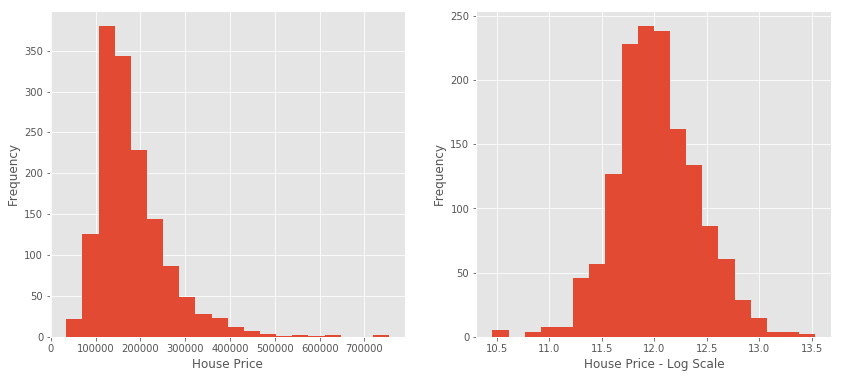

In [584]:
house.sales_hist()

# Scatter Plot against SalePrice - Numerical Features

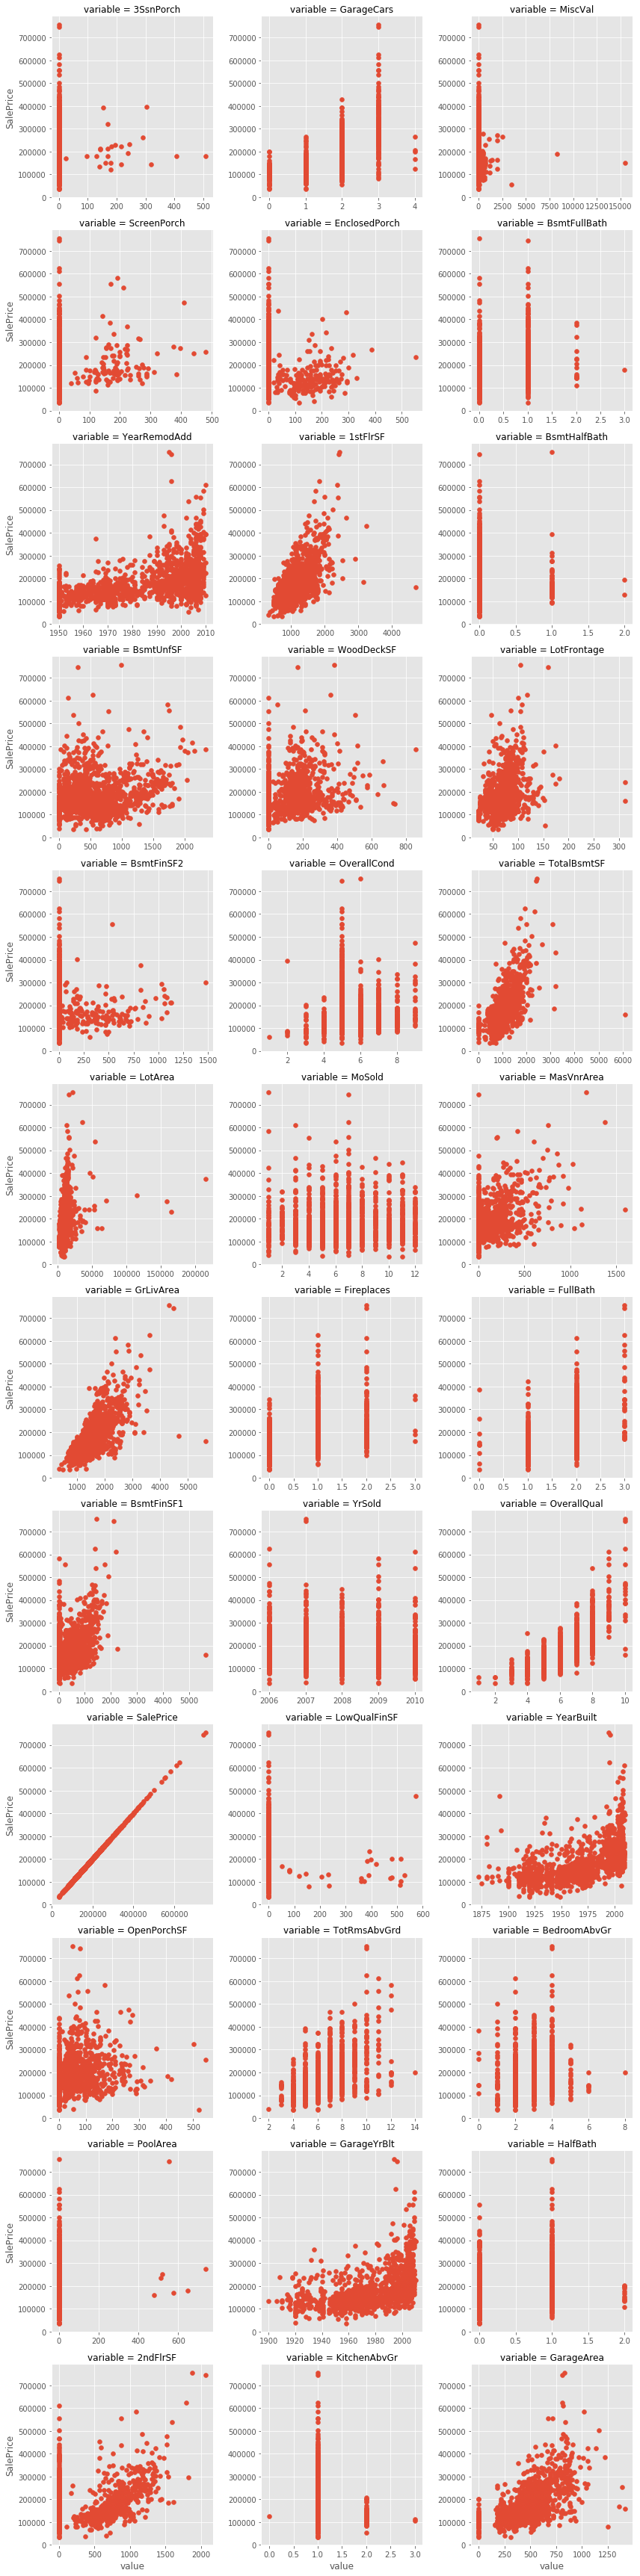

In [5]:
house.numeric_feature_grid_plot()

# Box Plot against SalePrice - Categorial Features

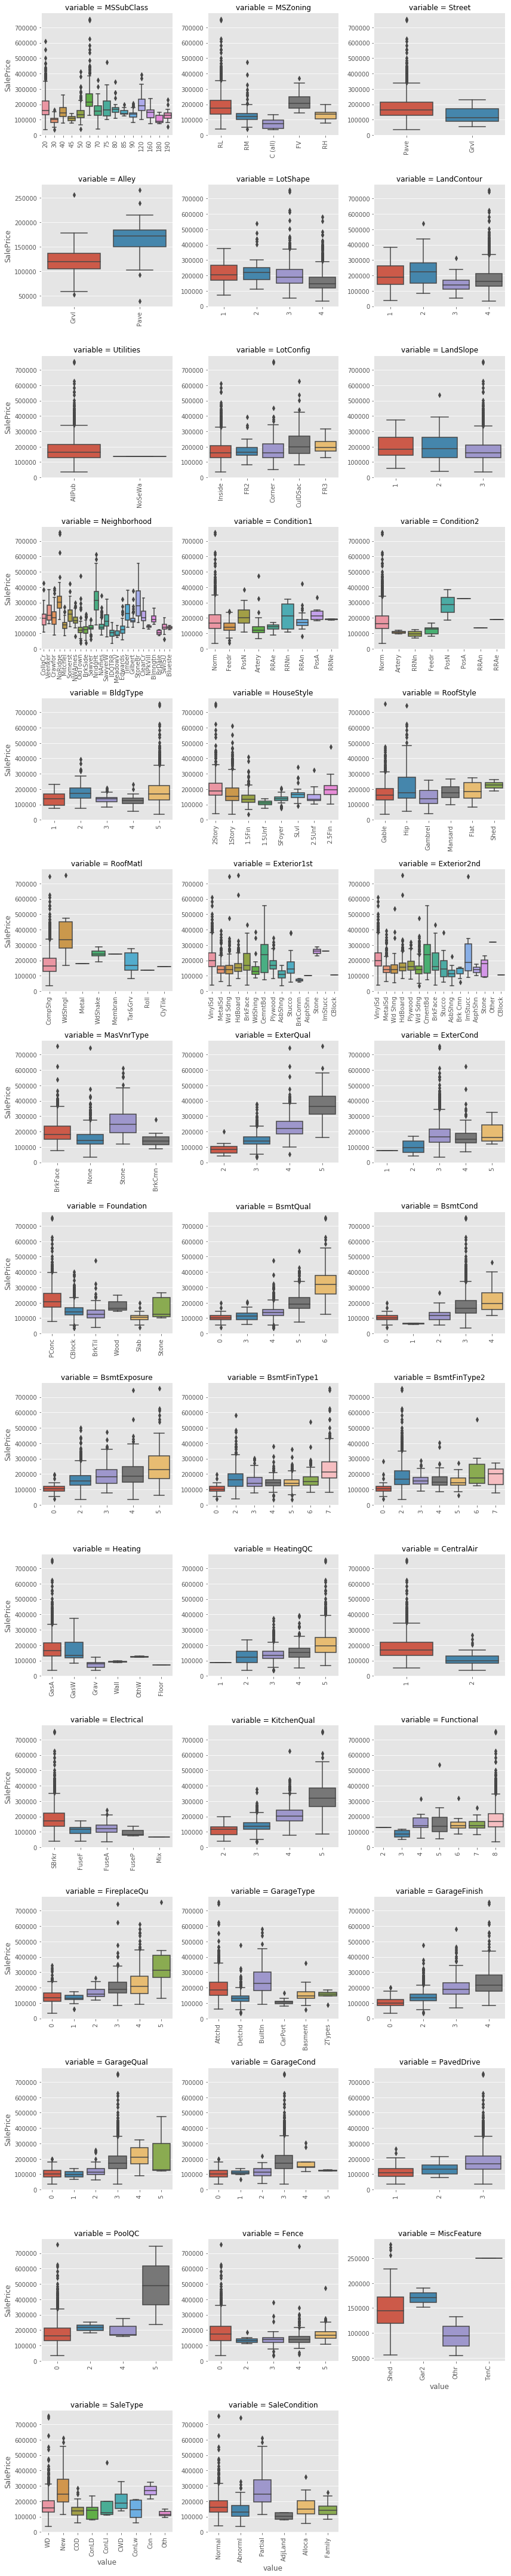

In [7]:
house.category_feature_grid_plot()

# Correlation Plot with SalePrice

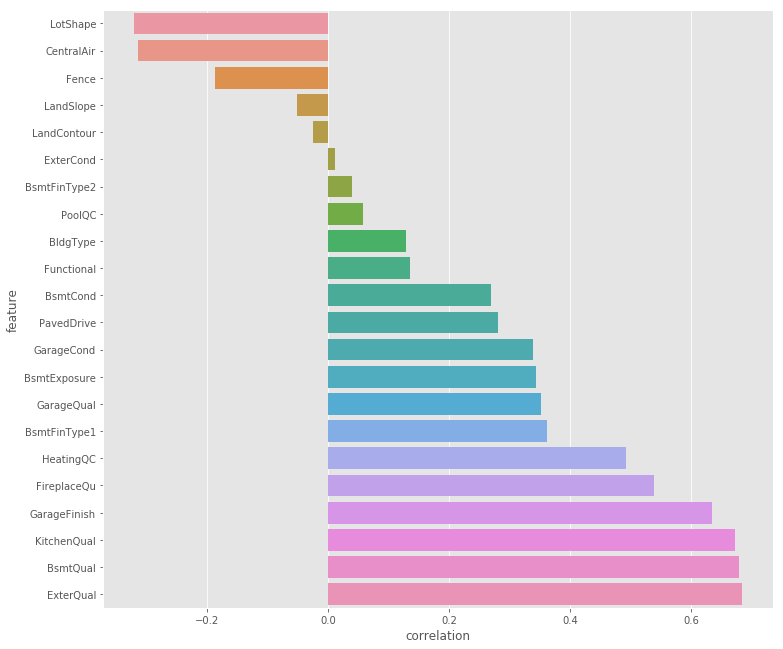

In [6]:
house.corr_plot_with_price()

# Bar Plot - Missing Values

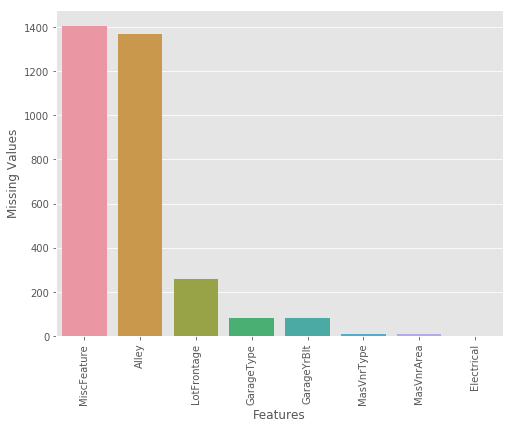

In [10]:
house.barplot_missing_values()

# Impute Missing Value

In [11]:
house.impute_values()

# Convert Category Features Before Skew Checking

In [12]:
y_data = house.get_train_data()['SalePrice']
x_data = house.get_train_data().drop('SalePrice', axis=1)
all_data = pd.concat([x_data, house.get_test_data()], ignore_index=True)
all_data_linear = pd.get_dummies(all_data, drop_first=True, dummy_na=True)

# skewed_features = all_data[house.get_feature_numeric()].apply(skew, axis=0)
skewed_features = all_data_linear.apply(skew, axis=0)
skewed_features = skewed_features[skewed_features>0.75]
# all_data[skewed_features.index] = all_data[skewed_features.index].apply(np.log1p, axis=1)
all_data_linear[skewed_features.index] = all_data_linear[skewed_features.index].apply(np.log1p, axis=1)

# Linear Regression

In [13]:
X = all_data_linear[:len(house.get_train_data())]
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3, random_state=24)

In [15]:
lm_model = LinearRegression()
lm_model.fit(X_train, np.log(y_train))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
lm_model.score(X_test, np.log(y_test))

0.755093178218608

In [17]:
def get_coefficient(model, colnames):
    result = pd.DataFrame(model.coef_).transpose()
    result.columns = colnames.tolist()
    result['intercept'] = model.intercept_ 
    result = result.transpose()
    result.columns = ['coefficient']
    return result.sort_values(by='coefficient', ascending=False)

#lm_coef = get_coefficient(lm_model, X_train.columns)
# lm_coef

# Convert Category Features using LabelCountEncoder 

In [18]:
train_index = len(house.get_train_data())
all_data_lce = pd.concat([x_data, house.get_test_data()], ignore_index=True)

for feature in house.get_feature_category():
    lce = LabelCountEncoder()
    all_data_lce.loc[:train_index, feature]=lce.fit_transform(all_data_lce.loc[:train_index, feature])
    all_data_lce.loc[train_index:, feature]=lce.transform(all_data_lce.loc[train_index:,feature])
    
X_lce = all_data_lce[:train_index]
X_train_lce, X_test_lce, y_train_lce, y_test_lce = train_test_split(X_lce, y_data, test_size=0.3, random_state=24)

# standardize the training data
scaler = StandardScaler().fit(X_train_lce)
X_train_lce_scale = scaler.transform(X_train_lce)
X_test_lce_scale = scaler.transform(X_test_lce)

# Gridsearch for Ridge

In [451]:
alpha_60 = np.logspace(-2, 5, 60)

ridge_model = Ridge(random_state=24)
grid_param = [{'alpha': alpha_60}]
grid_ridge = GridSearchCV(estimator=ridge_model, param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
%time grid_ridge = grid_ridge.fit(X_train_lce_scale, np.log(y_train_lce))

CPU times: user 1.04 s, sys: 30.2 ms, total: 1.07 s
Wall time: 976 ms


In [452]:
grid_ridge.best_estimator_

Ridge(alpha=245.37511066398167, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=24, solver='auto',
   tol=0.001)

In [453]:
grid_ridge.best_score_

-0.025084373804698377

In [454]:
best_ridge = grid_ridge.best_estimator_ 
best_ridge.fit(X_train_lce_scale, np.log(y_train_lce))
best_ridge.score(X_test_lce_scale, np.log(y_test_lce))

0.8812226409796321

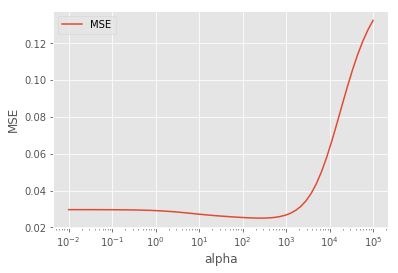

In [550]:
cv_result = pd.DataFrame({'MSE': -grid_ridge.cv_results_['mean_test_score'],
                          'alpha': grid_ridge.cv_results_['param_alpha'].data})
# cv_result['alpha']=np.log(cv_result['alpha'].astype('float'))
cv_result.plot(x='alpha', y='MSE', logx=True)
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.show()

In [1]:
# ridge_coef = get_coefficient(best_ridge, X_train_lce.columns)
# ridge_coef

# Gridsearch for Lasso 

In [445]:
alpha_60 = np.logspace(-2, 5, 60)
lasso_model = Lasso(random_state=24)
grid_param = [{'alpha': alpha_60}]
grid_lasso = GridSearchCV(estimator=lasso_model, param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
%time grid_lasso = grid_lasso.fit(X_train_lce_scale, np.log(y_train_lce))

CPU times: user 1.04 s, sys: 13 ms, total: 1.05 s
Wall time: 1.06 s


In [418]:
grid_lasso.best_estimator_

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=24,
   selection='cyclic', tol=0.0001, warm_start=False)

In [419]:
grid_lasso.best_score_

0.8264852797683188

In [420]:
best_lasso = grid_lasso.best_estimator_ 
best_lasso.fit(X_train_lce_scale, np.log(y_train_lce))
best_lasso.score(X_test_lce_scale, np.log(y_test_lce))

0.8820604832356147

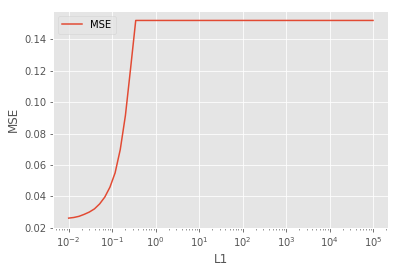

In [551]:
cv_result = pd.DataFrame({'MSE': -grid_lasso.cv_results_['mean_test_score'],
                          'L1': grid_lasso.cv_results_['param_alpha'].data})
cv_result.plot(x='L1', y='MSE', logx=True)
plt.xlabel('L1')
plt.ylabel('MSE')
plt.show()

In [2]:
# lasso_coef = get_coefficient(best_lasso, X_train_lce.columns)
# lasso_coef_important = abs(lasso_coef['coefficient'])>0
# lasso_coef[lasso_coef_important]

# Gridsearch for ElasticNet 

In [19]:
alpha_60 = np.logspace(-2, 5, 60)
l1_10 = np.linspace(0.1, 0.9, 9)
enet_model = ElasticNet(random_state=24)
grid_param = [{'alpha': alpha_60, 'l1_ratio': l1_10}]
grid_enet = GridSearchCV(estimator=enet_model, param_grid=grid_param, scoring='neg_mean_squared_error', cv=5, return_train_score=True)
%time grid_enet = grid_enet.fit(X_train_lce_scale, np.log(y_train_lce))

CPU times: user 14.4 s, sys: 141 ms, total: 14.5 s
Wall time: 14.6 s


In [424]:
grid_enet.best_score_

0.832858678646958

In [24]:
grid_enet.best_estimator_

ElasticNet(alpha=0.06768750009458535, copy_X=True, fit_intercept=True,
      l1_ratio=0.1, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=24, selection='cyclic', tol=0.0001,
      warm_start=False)

In [25]:
best_enet = grid_enet.best_estimator_
best_enet.fit(X_train_lce_scale, np.log(y_train_lce))
best_enet.score(X_test_lce_scale, np.log(y_test_lce))

0.884730649546476

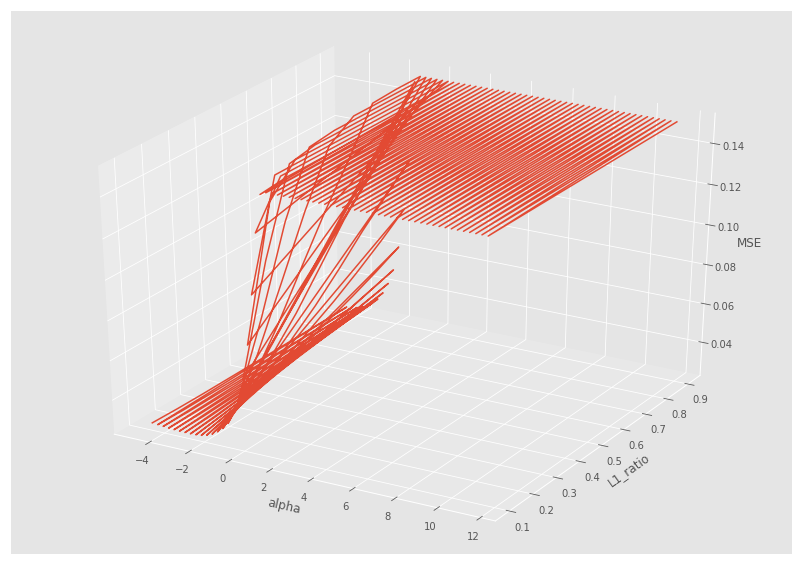

In [580]:
from mpl_toolkits import mplot3d
alpha_enet = np.array(grid_enet.cv_results_['param_alpha'].data)
alpha_enet.reshape(60, 9)
np.array(-grid_lasso.cv_results_['mean_test_score'])
MSE_enet = np.array(-grid_enet.cv_results_['mean_test_score'])
MSE_enet.reshape(60,9)
l1_enet = np.array(grid_enet.cv_results_['param_l1_ratio'].data)
l1_enet.reshape(60,9)

xline = np.log(alpha_enet.astype('float'))
plt.figure(figsize=(14,10))
ax = plt.axes(projection='3d')
ax.plot3D(xline, l1_enet, MSE_enet)
ax.set_xlabel('alpha')
ax.set_ylabel('L1_ratio')
ax.set_zlabel('MSE')
ax.view_init(30)
plt.draw()

In [3]:
# enet_coef = get_coefficient(best_enet, X_train_lce.columns)
# enet_coef_important = abs(enet_coef['coefficient'])>0
# enet_coef[enet_coef_important]

# Gridsearch for Random Forest

In [395]:
random_forest = RandomForestRegressor()

grid_para_forest = [{
    "n_estimators": [25, 50, 100, 250, 500],
    "criterion": ["mse"],
    "max_features": ["sqrt"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "oob_score": ["True"],
    "random_state": [24]}]
grid_forest = GridSearchCV(random_forest, grid_para_forest, scoring='r2', cv=5, return_train_score=True, n_jobs=-1)
%time grid_forest.fit(X_train_lce, np.log(y_train_lce))

CPU times: user 11.7 s, sys: 2.69 s, total: 14.4 s
Wall time: 8min 52s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [25, 50, 100, 250, 500], 'criterion': ['mse'], 'max_features': ['sqrt'], 'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'oob_score': ['True'], 'random_state': [24]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [552]:
grid_forest.best_params_

{'criterion': 'mse',
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 250,
 'oob_score': 'True',
 'random_state': 24}

In [553]:
grid_forest.best_score_

0.8677112233554384

In [554]:
best_forest = grid_forest.best_estimator_ 
best_forest.fit(X_train_lce, np.log(y_train_lce))
best_forest.score(X_test_lce, np.log(y_test_lce))

0.8683441341518884

In [4]:
def get_feature_importance(model, colnames):
    result = pd.DataFrame(model.feature_importances_).transpose()
    result.columns = colnames.tolist()
    result = result.transpose()
    result.columns = ['importance']
    return result.sort_values(by='importance', ascending=False)

# get_feature_importance(best_forest, X_train_lce.columns)

# Gridsearch for XGBoost

In [401]:
xgb_model = xgb.XGBRegressor()

para_xgb = [{
              'learning_rate': [0.1], #so called `eta` value
              'max_depth': [3, 5, 7, 9],
              'min_child_weight': [2, 3, 4],
              'silent': [1],
              'subsample': [0.7, 0.9],
              'colsample_bytree': [0.5, 0.7, 0.9],
              'n_estimators': [500,1000, 2000], #number of trees, change it to 1000 for better results
              'random_state': [24]}]
grid_xgb = GridSearchCV(xgb_model, para_xgb, scoring='r2', cv=5, return_train_score=True, n_jobs=-1)
%time grid_xgb.fit(X_train_lce, np.log(y_train_lce))

CPU times: user 4.93 s, sys: 951 ms, total: 5.88 s
Wall time: 16min 46s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'learning_rate': [0.1], 'max_depth': [3, 5, 7, 9], 'min_child_weight': [2, 3, 4], 'silent': [1], 'subsample': [0.7, 0.9], 'colsample_bytree': [0.5, 0.7, 0.9], 'n_estimators': [500, 1000, 2000], 'random_state': [24]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [555]:
grid_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 500,
 'random_state': 24,
 'silent': 1,
 'subsample': 0.7}

In [403]:
grid_xgb.best_score_

0.8951123714981468

In [556]:
best_xgb = grid_xgb.best_estimator_ 
best_xgb.fit(X_train_lce, np.log(y_train_lce))
best_xgb.score(X_test_lce, np.log(y_test_lce))

0.9096853162050742

Text(0,0.5,'R2')

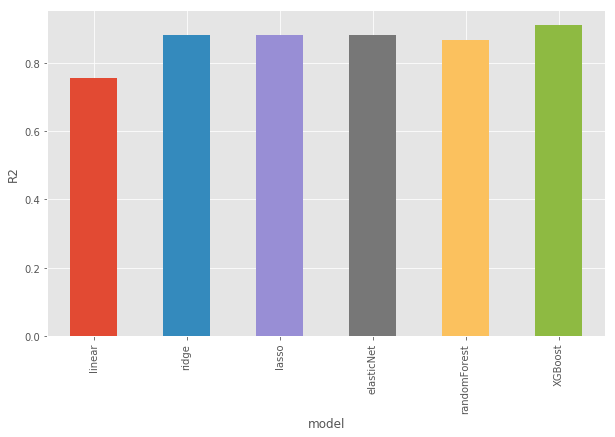

In [576]:
cv_compare = pd.DataFrame({'model': ['linear', 'ridge', 'lasso', 'elasticNet',
                                     'randomForest', 'XGBoost'],
                          'R2': [lm_model.score(X_test, np.log(y_test)),
                                 best_ridge.score(X_test_lce_scale, np.log(y_test_lce)),
                                 best_lasso.score(X_test_lce_scale, np.log(y_test_lce)),
                                 best_enet.score(X_test_lce_scale, np.log(y_test_lce)),
                                 best_forest.score(X_test_lce, np.log(y_test_lce)),
                                 best_xgb.score(X_test_lce, np.log(y_test_lce))]})
cv_compare.plot.bar(x='model', y='R2', figsize=(10,6), legend=False)
plt.xlabel('model')
plt.ylabel('R2')

In [6]:
#get_feature_importance(best_xgb, X_train_lce.columns)

# Ensemble by Stacking Models

In [577]:
from stacking import stacking_regression
def get_rmse(y, y_pred):
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))

In [578]:
X_train = all_data_lce.iloc[:train_index,:]
X_test = all_data_lce.iloc[train_index:,:]

models = [
    # Random Forest model
    RandomForestRegressor(n_estimators=250, max_features='sqrt', criterion='mse',
                          min_samples_leaf=1, min_samples_split=2, oob_score=True,
                          random_state=24),
    
    # XGBoost model
    xgb.XGBRegressor(learning_rate=0.1, max_depth=3, min_child_weight=2, 
                    n_estimators=1000, subsample=0.7, colsample_bytree=0.5,
                    random_state=24, silent=1) 
    ]

meta_model = ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=24)

In [ ]:
%%time 
final_prediction = stacking_regression(models, meta_model, X_train, y_data, 
                               X_test, transform_target=np.log, transform_pred = np.exp, 
                               metric=get_rmse, verbose=1)